<a href="https://colab.research.google.com/github/huhjayeon/cbm-prediction-model/blob/main/cbm_prediction_RandomForestRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CBM 예측 RandomForestRegressor (랜덤 포레스트 회귀) 모델
###- SKU 총 부피를 기준으로, 팔레트의 총 부피를 예측

##1. 데이터 전처리

####**이상치 선정 근거 1: 팔레트 바닥 면적 고정**


*  팔레트 바닥 면적: 1.21 m³ (1.1m × 1.1m)
*  부피가 1.21 m³ 미만인 팔레트는 이상치로 간주하여 해당 패킹넘버 제거.






####**이상치 선정 근거 2 : 팔레트 최대 높이 제한**

*  팔레트 높이 최대: 2.4m

*  패킹넘버별 최대 부피 계산:
#####max_possible_cbm = pallet_count x (1.1×1.1×2.4)

#####**실제 출고 부피 (total_pckg_cbm)**가 최대 부피를 초과하면 이상치로 간주하여 제거.

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
import numpy as np


# 데이터 로드
pckg_cbm = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/cms/data/cbm/tb_pckg_cbm_fin.csv')
pckg_prod = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/cms/data/cbm/tb_pckg_prod_fin.csv')

# 데이터 전처리
# SKU 종류와 수량 계산
sku_count = pckg_prod.groupby('pckg_no')['prod_cd'].nunique().reset_index()
sku_count.rename(columns={'prod_cd': 'sku_count'}, inplace=True)

total_qty = pckg_prod.groupby('pckg_no')['qty'].sum().reset_index()
total_qty.rename(columns={'qty': 'total_qty'}, inplace=True)

# SKU 총 부피 계산
sku_total_volume = pckg_prod.groupby('pckg_no')['total_prod_volume'].sum().reset_index()
sku_total_volume.rename(columns={'total_prod_volume': 'sku_total_volume'}, inplace=True)

# 패킹 데이터와 병합
pallet_total_cbm = pckg_cbm[['pckg_no', 'total_pckg_cbm']].drop_duplicates()
merged_data = pd.merge(sku_total_volume, pallet_total_cbm, on='pckg_no')
merged_data = pd.merge(merged_data, sku_count, on='pckg_no')
merged_data = pd.merge(merged_data, total_qty, on='pckg_no')

# 팔레트 높이 추가
merged_data['pallet_height'] = merged_data['total_pckg_cbm'] / (1.1 * 1.1)  # 가로와 세로는 1.1m 고정

# 패킹넘버별 팔레트 개수 계산
pallet_counts = pckg_cbm.groupby('pckg_no').size().reset_index(name='pallet_count')

# 팔레트 개수와 최대 가능한 부피 계산
pallet_counts['max_possible_cbm'] = pallet_counts['pallet_count'] * (1.1 * 1.1 * 2.4)  # 1.1m x 1.1m x 2.4m

# 패킹 데이터와 병합
merged_with_counts = pd.merge(merged_data, pallet_counts, on='pckg_no')

# 이상치 탐지 (실제 total_pckg_cbm > max_possible_cbm)
outliers = merged_with_counts[merged_with_counts['total_pckg_cbm'] > merged_with_counts['max_possible_cbm']]

# 이상치 출력
print("이상치로 감지된 데이터:")
print(outliers[['pckg_no', 'total_pckg_cbm', 'pallet_count', 'max_possible_cbm']])

# 이상치 제거
filtered_data = merged_with_counts[merged_with_counts['total_pckg_cbm'] <= merged_with_counts['max_possible_cbm']]
print('')
print(f"이상치 제거 후 데이터 크기: {filtered_data.shape}")
print('')





이상치로 감지된 데이터:
         pckg_no  total_pckg_cbm  pallet_count  max_possible_cbm
1580  PK00120384        347.8750             3             8.712
1815  PK00123957          6.8486             2             5.808
2423  PK00132288        132.4950             1             2.904

이상치 제거 후 데이터 크기: (3351, 8)



##2. 모델 학습

Fitting 3 folds for each of 50 candidates, totalling 150 fits

RandomizedSearchCV 최적 하이퍼파라미터: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
RandomizedSearchCV 최적 Mean Absolute Error (MAE): 0.04

테스트 데이터 MAE: 0.06
테스트 데이터 RMSE: 1.24




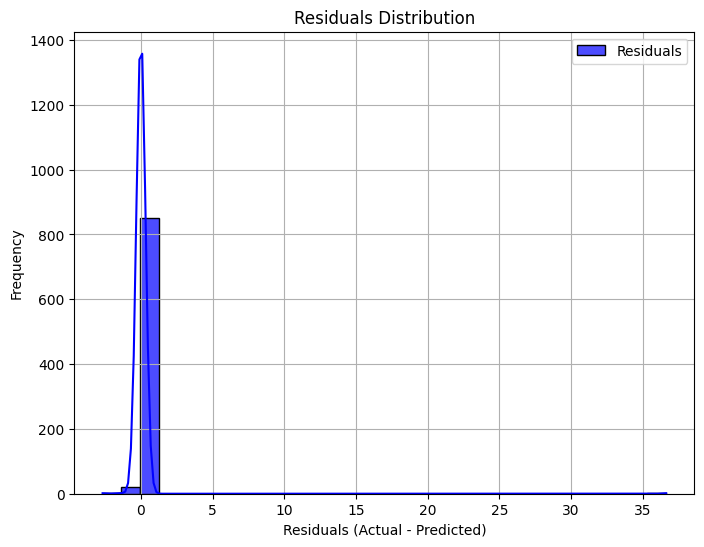

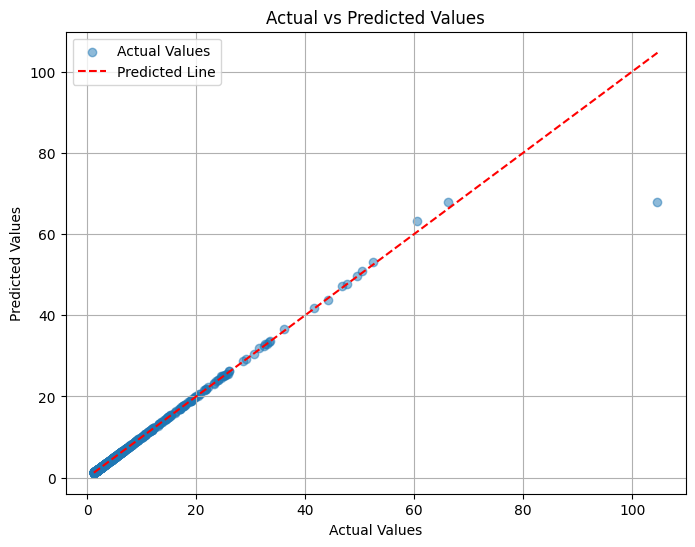

In [18]:
# 독립 변수와 종속 변수 설정
X = filtered_data[['sku_total_volume', 'sku_count', 'total_qty', 'pallet_height']]
y = filtered_data['total_pckg_cbm']

# 하한값 설정 (y > 1.21)
lower_bound = 1.21
valid_indices = y[y > lower_bound].index
X = X.loc[valid_indices]
y = y.loc[valid_indices]

# 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# RandomizedSearchCV로 하이퍼파라미터 튜닝
param_distributions = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=50,  # 최대 50개의 조합 탐색
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# 모델 학습
random_search.fit(X_train, y_train)

# 최적 하이퍼파라미터 및 성능 출력
best_params_random = random_search.best_params_
best_score_random = -random_search.best_score_

print('')
print("RandomizedSearchCV 최적 하이퍼파라미터:", best_params_random)
print(f"RandomizedSearchCV 최적 Mean Absolute Error (MAE): {best_score_random:.2f}")
print('')

# 최적 모델로 테스트 데이터 예측
best_model = random_search.best_estimator_
y_test_pred = best_model.predict(X_test)

# 테스트 데이터 평가
mae = mean_absolute_error(y_test, y_test_pred)
rmse = root_mean_squared_error(y_test, y_test_pred)

print(f"테스트 데이터 MAE: {mae:.2f}")
print(f"테스트 데이터 RMSE: {rmse:.2f}")
print('')
print('')


# 시각화: 잔차 분포
residuals = y_test - y_test_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='blue', alpha=0.7, label="Residuals")
plt.title("Residuals Distribution")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.legend()  # 범례 추가
plt.grid()
plt.show()


# 시각화: 실제값 vs 예측값
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, label="Actual Values")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Predicted Line")
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()  # 범례 추가
plt.grid()
plt.show()


##3. 잔차 큰 데이터 확인

In [19]:
# 실제값 (y_test)와 예측값 (y_test_pred) 정리
actual_data = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred,
    'Error': abs(y_test - y_test_pred)
})

# 내림차순 정렬
actual_data_sorted = actual_data.sort_values(by='Actual', ascending=False)

# 상위 5개 값 확인
print("Actual 값 내림차순 상위 데이터:")
print(actual_data_sorted.head(5))

# 패킹넘버를 찾기 위해 인덱스를 기준으로 원본 데이터 조회
outlier_indices = actual_data_sorted.head(5).index
outlier_info = merged_with_counts.loc[outlier_indices, ['pckg_no', 'total_pckg_cbm']]

print("\n해당 패킹넘버와 총 부피 정보:")
print(outlier_info)


Actual 값 내림차순 상위 데이터:
        Actual  Predicted      Error
1628  104.6408  68.001782  36.639018
3070   66.2233  67.769913   1.546613
2874   60.5484  63.223441   2.675041
1655   52.4414  53.127407   0.686007
805    50.4570  50.772140   0.315140

해당 패킹넘버와 총 부피 정보:
         pckg_no  total_pckg_cbm
1628  PK00121145        104.6408
3070  PK00140177         66.2233
2874  PK00137701         60.5484
1655  PK00121458         52.4414
805   PK00108002         50.4570


##4. K-Fold Cross Validation  
교차검증

In [20]:
# K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(best_model, X, y, cv=kfold, scoring='neg_mean_absolute_error')

print("K-Fold Cross Validation MAE Scores:", -cross_val_scores)
print(f"Average MAE: {-np.mean(cross_val_scores):.2f}")

K-Fold Cross Validation MAE Scores: [0.06989826 0.02120025 0.01894212 0.03673507 0.02735134]
Average MAE: 0.03
